In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)
from scipy.stats import mode
from scipy import stats
import feather
import re
import warnings
import random

from IPython.display import clear_output

In [2]:
target = pd.read_csv('target2',header=None,index_col=0)

In [3]:
list_of_best_cols = feather.read_dataframe('test_all_addition_best_fit')['cols'].values

In [4]:
################ everything ################ CV score: 3.69761
train = feather.read_dataframe('train')
test = feather.read_dataframe('test')
########################################

In [5]:
############################ best so far ############################
train = feather.read_dataframe('merchants_and_city_id\\all_additional_train')
test = feather.read_dataframe('merchants_and_city_id\\all_additional_test')

In [6]:
if 'best_cols' in locals():
    features = [c for c in best_cols if c not in ['card_id', 'first_active_month','last_active_month']]
else:
    features = [c for c in train.columns if c not in ['card_id', 'first_active_month','last_active_month']]
categorical_feats = [x for x in features if (re.search('modeplus',x) or re.search('feature_',x))]

In [11]:
warnings.filterwarnings("ignore")
param = {
        'num_leaves': 111, #checked
         'num_threads': 4,
         'max_bin': 150, #checked
         'min_data_in_leaf': 100, #checked
         'objective':'regression',
         'max_depth': 9, #checked
         'tree_learner':'data',
         'learning_rate': 0.07,
         "boosting": "gbdt", #dart, gbdt
         "feature_fraction": 0.75, #checked
         "bagging_freq": 5, #5
         "bagging_fraction": 0.75, #checked
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.26, #checked
#            'lambda_l2': 0.3, #checked
         "random_state": 77,
         "verbosity": -1,
         "device":"gpu",
         'gpu_device_id':0,
         'gpu_platform_id':1,
         'gpu_use_dp':True,
        }


folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))

    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )


    clf = lgb.train(param, trn_data,100000, valid_sets = [trn_data, val_data], verbose_eval=250, early_stopping_rounds = 200)

    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits
errr = mean_squared_error(oof, target)**0.5
print("CV score: {:<8.5f}".format(errr))
#test3.65985   n3 3.78281

fold n°0
Training until validation scores don't improve for 200 rounds.
[250]	training's rmse: 3.08702	valid_1's rmse: 3.68898
Early stopping, best iteration is:
[62]	training's rmse: 3.4274	valid_1's rmse: 3.67375
fold n°1
Training until validation scores don't improve for 200 rounds.
[250]	training's rmse: 3.10112	valid_1's rmse: 3.63897
Early stopping, best iteration is:
[64]	training's rmse: 3.43668	valid_1's rmse: 3.62065
fold n°2
Training until validation scores don't improve for 200 rounds.
[250]	training's rmse: 3.10242	valid_1's rmse: 3.61342
Early stopping, best iteration is:
[50]	training's rmse: 3.47074	valid_1's rmse: 3.59708
fold n°3
Training until validation scores don't improve for 200 rounds.
[250]	training's rmse: 3.06865	valid_1's rmse: 3.79897
Early stopping, best iteration is:
[63]	training's rmse: 3.39655	valid_1's rmse: 3.78281
fold n°4
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[44]	training's rmse: 3.48941	

In [ ]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [ ]:
best_cols = pd.DataFrame(best_features.groupby(['feature'])['importance'].mean()).sort_values(by='importance')
best_cols

In [ ]:
to_drop = (set(best_cols.index) - set(list_of_best_cols))

In [ ]:
to_drop = best_cols.loc[to_drop]

In [ ]:
to_add = to_drop.sort_values(by='importance',ascending=False)[:100]

In [ ]:
train_train_columns = train[list(to_add.index) + ['card_id']]
test_train_columns = test[list(to_add.index) + ['card_id']]

In [ ]:
train = pd.merge(train,train_train_columns,how='left',on='card_id')
test = pd.merge(test,test_train_columns,how='left',on='card_id')

In [145]:
warnings.filterwarnings("ignore")

if 'best_cols' in locals():
    features = [c for c in best_cols if c not in ['card_id', 'first_active_month','last_active_month']]
else:
    features = [c for c in train.columns if c not in ['card_id', 'first_active_month','last_active_month']]
categorical_feats = [x for x in features if (re.search('modeplus',x) or re.search('feature_',x))]

param = {
        'num_leaves': 111, #checked
         'num_threads': 4,
         'max_bin': 150, #checked
         'min_data_in_leaf': 100, #checked
         'objective':'regression',
         'max_depth': 9, #checked
         'tree_learner':'data',
         'learning_rate': 0.07,
         "boosting": "gbdt", #dart, gbdt
         "feature_fraction": 0.9, #checked 0.75
         "bagging_freq": 5, #5
         "bagging_fraction": 0.9, #checked 0.75
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.26, #checked
#            'lambda_l2': 0.3, #checked
         "random_state": 77,
         "verbosity": -1,
         "device":"gpu",
         'gpu_device_id':0,
         'gpu_platform_id':1,
         'gpu_use_dp':True,
        }


folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))

    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )


    clf = lgb.train(param, trn_data,100000, valid_sets = [trn_data, val_data], verbose_eval=250, early_stopping_rounds = 200)

    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits
errr = mean_squared_error(oof, target)**0.5
print("CV score: {:<8.5f}".format(errr))
#test 3.65985   n3 3.78281
#test 3.65344   n3 3.78007

fold n°0
Training until validation scores don't improve for 200 rounds.
[250]	training's rmse: 2.97608	valid_1's rmse: 3.68813
Early stopping, best iteration is:
[64]	training's rmse: 3.35413	valid_1's rmse: 3.66969
fold n°1
Training until validation scores don't improve for 200 rounds.
[250]	training's rmse: 3.00489	valid_1's rmse: 3.62999
Early stopping, best iteration is:
[70]	training's rmse: 3.36144	valid_1's rmse: 3.61661
fold n°2
Training until validation scores don't improve for 200 rounds.
[250]	training's rmse: 2.97852	valid_1's rmse: 3.60078
Early stopping, best iteration is:
[66]	training's rmse: 3.36491	valid_1's rmse: 3.59082
fold n°3
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[47]	training's rmse: 3.3791	valid_1's rmse: 3.78007
fold n°4
Training until validation scores don't improve for 200 rounds.
[250]	training's rmse: 2.96877	valid_1's rmse: 3.62186
Early stopping, best iteration is:
[73]	training's rmse: 3.33626	

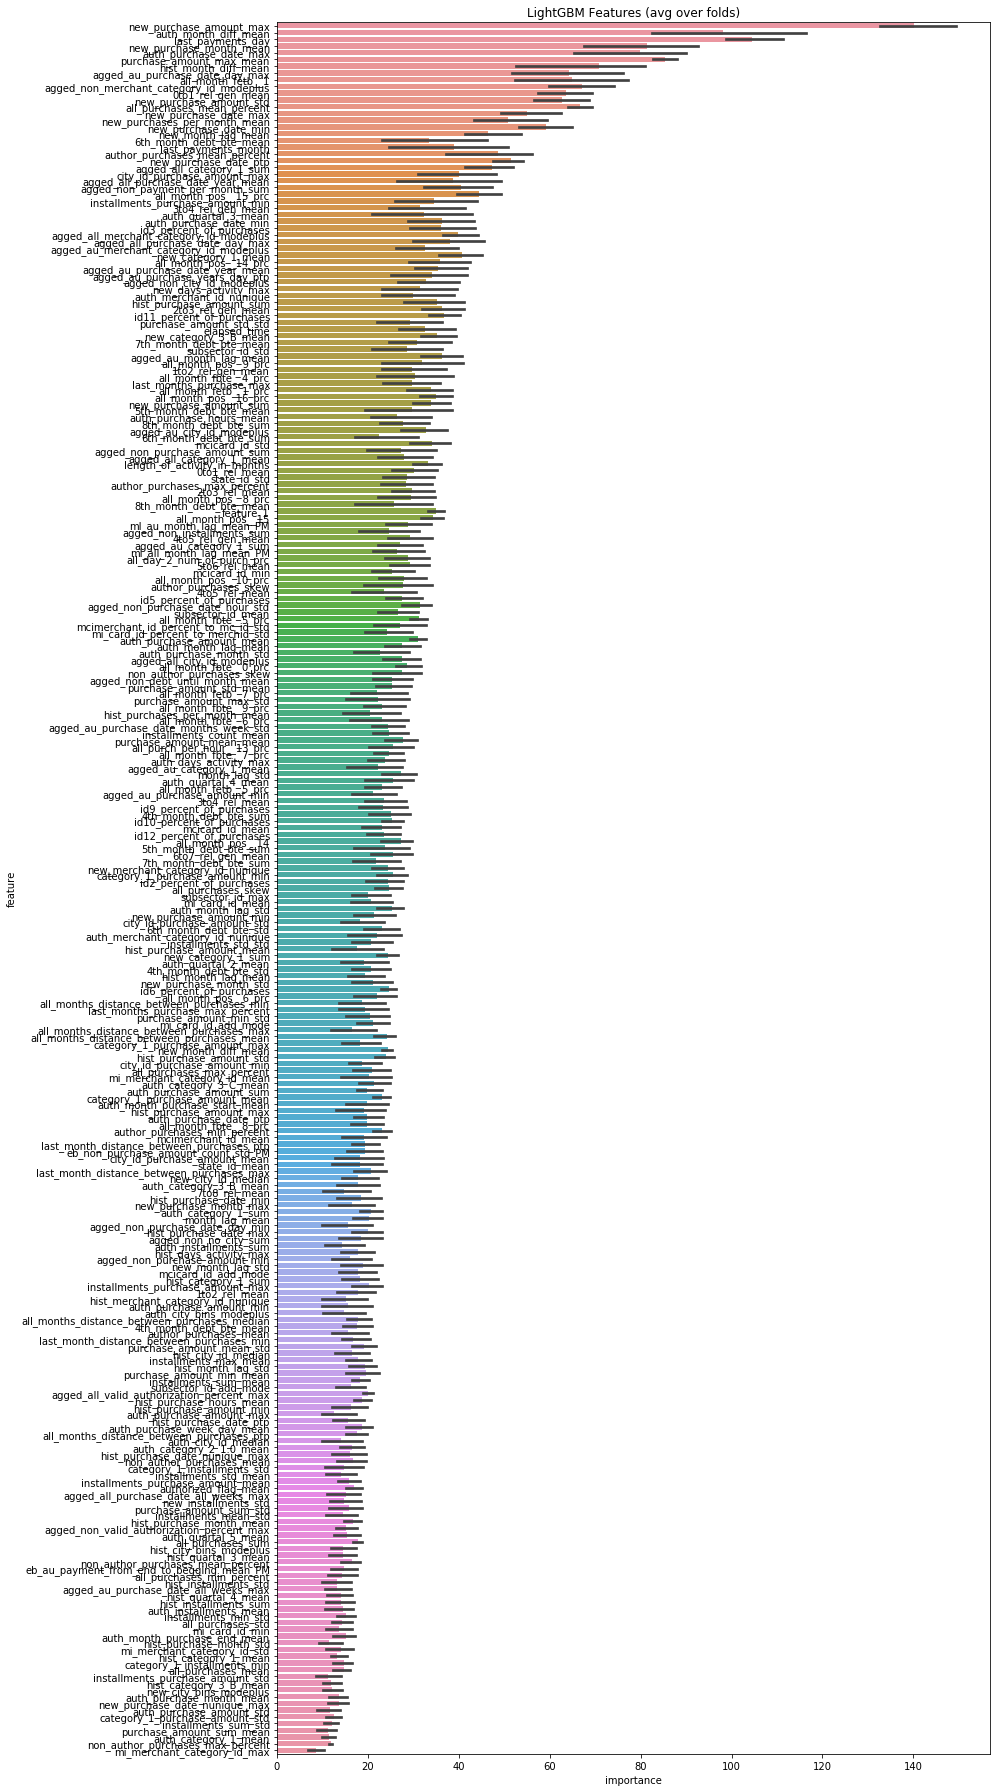

In [144]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [138]:
all_cols = pd.DataFrame(best_features.groupby(['feature'])['importance'].mean()).sort_values(by='importance')
all_cols

,importance
feature,
hist_category_1_mean,9.0
installments_sum_std,9.6
auth_installments_mean,10.4
mi_merchant_category_id_max,10.6
auth_category_2_1.0_mean,10.6
hist_city_id_median,11.0
hist_purchase_month_std,11.2
category_1_purchase_amount_std,11.4
all_purchases_min_percent,11.4


In [140]:
best_cols = all_cols[all_cols.importance > 11].index

In [136]:
best_rn = best_cols

In [142]:
#best_cols = best_rn

In [146]:
train = train[best_cols]
test = test[best_cols]

In [147]:
feather.write_dataframe(train,'best_table\\train')
feather.write_dataframe(test,'best_table\\test')

In [8]:
columns_I_need = feather.read_dataframe('best_table\\train').columns

In [12]:
################ everything ################ CV score: 3.69761
train = feather.read_dataframe('train')
test = feather.read_dataframe('test')
############################################

In [13]:
############################ best so far ############################
train2 = feather.read_dataframe('merchants_and_city_id\\all_additional_train')
test2 = feather.read_dataframe('merchants_and_city_id\\all_additional_test')

In [18]:
tstay = list(set(train.columns) - set(train2))+ ['card_id']

In [19]:
train = pd.merge(train[tstay],train2,how='left',on='card_id')
test = pd.merge(test[tstay],test2,how='left',on='card_id')

In [10]:
columns_I_need = list(columns_I_need) + ['card_id']

In [20]:
train = train[columns_I_need]
test = test[columns_I_need]